In [14]:
from torchvision.datasets.utils import download_url

download_url("https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz", "data")

In [15]:
import os
import tarfile

with tarfile.open("data/cifar10.tgz",'r') as tr:
	if not os.listdir("data").count("cifar10"):
		tr.extractall("data")

In [16]:
from torchvision import transforms

combined_transforms = transforms.Compose(
	transforms=[
		transforms.ToTensor(),
	]
)

In [17]:
from torch import randint
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(
	root="data/cifar10/train",
	transform=combined_transforms
)
test_dataset = ImageFolder(
	root="data/cifar10/test",
	transform=combined_transforms
)
img, lbl = train_dataset[randint(0, len(train_dataset), size=(1,)).item()]
len(train_dataset), len(test_dataset),len(train_dataset.classes)

(50000, 10000, 10)

In [18]:
from torch.utils.data import DataLoader

batch_size = 32
train_itr = DataLoader(
	dataset=train_dataset,
	batch_size=batch_size,
	shuffle=True,
)
test_itr = DataLoader(
	dataset=test_dataset,
	batch_size=batch_size,
	shuffle=True,
)
len(train_itr), len(test_itr)

(1563, 313)

In [19]:
from torch import nn, randn
import torch

class ClassifyObjects(nn.Module):
	def __init__(
			self,
			input_channels:int=3,
			output_channels:int=10,
			hidden_units:int=16,
			batch_size:int=32,
	):
		super().__init__()

		self.input_channels = input_channels
		self.output_channels = output_channels
		self.hidden_units = hidden_units
		self.batch_size = batch_size

		self.input_stack = nn.Sequential(
			nn.Conv2d(
				in_channels=self.input_channels,
				out_channels=self.hidden_units,
				kernel_size=3,
				stride=1,
				padding=0,
			),
			nn.ReLU(),
			nn.Conv2d(
				in_channels=self.hidden_units,
				out_channels=self.hidden_units*2,
				kernel_size=3,
				stride=1,
				padding=0,
			),
			nn.ReLU(),
			nn.MaxPool2d(
				kernel_size=2,
			),
		)
		self.hidden_stack0 = nn.Sequential(
			nn.Conv2d(
				in_channels=self.hidden_units*2,
				out_channels=self.hidden_units*2,
				kernel_size=3,
				stride=1,
				padding=1,
			),
			nn.ReLU(),
			nn.Conv2d(
				in_channels=self.hidden_units*2,
				out_channels=self.hidden_units,
				kernel_size=3,
				stride=1,
				padding=1,
			),
			nn.ReLU(),
			nn.MaxPool2d(
				kernel_size=2,
			),
		)
		self.output_stack = nn.Sequential(
			nn.Flatten(),
			nn.Linear(
				in_features=self.hidden_units*7*7,
				out_features=output_channels*4,
			),
			nn.ReLU(),
			nn.Linear(
				in_features=output_channels*4,
				out_features=output_channels*2,
			),
			nn.ReLU(),
			nn.Linear(
				in_features=output_channels*2,
				out_features=output_channels,
			)
		)
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		# x = self.input_stack(x)
		# # print(x.shape)
		# x = self.hidden_stack0(x)
		# print(x.shape)
		# x = self.output_stack(x)
		# print(x.shape)
		# return x
		return self.output_stack(self.hidden_stack0(self.input_stack(x)))
	def accuracy(self, prediction: torch.Tensor, real: torch.Tensor) -> float:
		return torch.eq(prediction.argmax(dim=1), real).sum().item()/self.batch_size

In [20]:
from torchinfo import summary


mdl = ClassifyObjects(
	input_channels=3,
	output_channels=10,
	hidden_units=8,
	batch_size=batch_size,
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
	params=mdl.parameters(),
	lr=0.01,
)
summary(mdl)

Layer (type:depth-idx)                   Param #
ClassifyObjects                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       224
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       1,168
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       2,320
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       1,160
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      15,720
│    └─ReLU: 2-13                        --
│    └─Linear: 2-14                      820
│    └─ReLU: 2-15                        --
│    └─Linear: 2-16                      210
Total params: 21,622
Trainable params: 21,622
Non-train

In [21]:
mdl.load_state_dict(state_dict=torch.load("saved_models/cifar10.pth", weights_only=True))

<All keys matched successfully>

In [39]:
epochs = 5

for epoch in range(epochs):
	mdl.train()
	for batch, (x, y) in enumerate(train_itr):
		preds = mdl(x)
		loss = loss_fn(preds, y)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

	mdl.eval()
	with torch.inference_mode():
		tacc, tloss = 0.0, 0.0
		for tx, ty in test_itr:
			tpreds = mdl(tx)
			tloss+=loss_fn(tpreds, ty)
			tacc+=mdl.accuracy(tpreds, ty)
		tacc/=len(test_itr)
		tloss/=len(test_itr)

	print(f"epoch:{epoch} acc:{tacc*100:.2f}% loss:{tloss:.2f}")

epoch:0 acc:63.29% loss:1.05
epoch:1 acc:64.28% loss:1.01
epoch:2 acc:64.05% loss:1.05
epoch:3 acc:61.31% loss:1.14
epoch:4 acc:64.48% loss:1.01


14/16


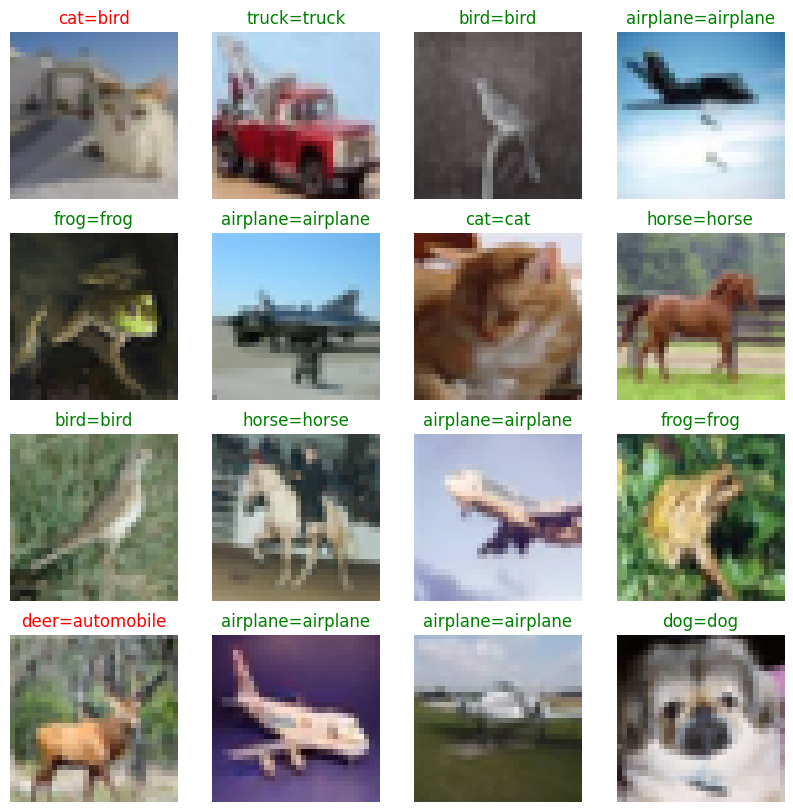

In [77]:
from matplotlib import pyplot as plt
from torch import randint
cnt = 0
fig = plt.figure(figsize=(10,10))
for i in range(16):
    img, label = train_dataset[randint(0, len(train_dataset), size=(1,)).item()]
    prediction = mdl(img.unsqueeze(0)).argmax(dim=1).item()
    fig.add_subplot(4,4,i+1)
    plt.imshow(img.permute(1,2,0))
    if prediction == label: cnt+=1
    plt.title(f"{train_dataset.classes[label]}={train_dataset.classes[prediction]}", color="green" if prediction == label else "red")
    plt.axis(False)
print(f"{cnt}/16")

In [40]:
import os
os.makedirs("saved_models", exist_ok=True)
torch.save(mdl.state_dict(), "saved_models/cifar10.pth")

In [25]:
mdl.eval()
with torch.inference_mode():
	tacc, tloss = 0.0, 0.0
	for tx, ty in test_itr:
		tpreds = mdl(tx)
		tloss+=loss_fn(tpreds, ty)
		tacc+=mdl.accuracy(tpreds, ty)
	tacc/=len(test_itr)
	tloss/=len(test_itr)
print(f"acc:{tacc*100:.2f}% loss:{tloss:.2f}")

acc:59.62% loss:1.17
